<a href="https://colab.research.google.com/github/AdithyaP7/MLWorkshops/blob/master/ReinforcementLearningBlackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Game of Blackjack

The most widely-played game of chance in casinos around the world is the card game Blackjack. Though you can be sure that the odds are *always* against the gambler, certain play strategies are better than others (in the sense that they provide the gambler with a smaller expected loss). Despite Blackjack having been played since the 17th century, it was not until 1956 that a team of statisticians managed to find the provably optimal play strategy through a lengthy series of probability calculations.

![](https://upload.wikimedia.org/wikipedia/commons/3/33/Blackjack21.jpg)

Here's a brief description of how the game works in its most basic form (you can find the full rules [here](https://en.wikipedia.org/wiki/Blackjack#Rules), but you don't need a detailed understanding for the purposes of this notebook). The general objective is to accumulate points, via playing cards, that sum as close to 21 as possible without exceeding it.

Each card in the deck has a numeric value between 2 and 10, except for one type of card - an "ace" - which can be worth either 1 or 11. The value of a hand is given by the sum of the values of its cards. We (the gambler) are dealt two cards, both of which we can see. Our opponent (the dealer) is also dealt two cards, of which we can see only one.

We are first given the option to draw additional cards - one by one, as many as we'd like - to try to improve our hand. This is called "hitting". If we exceed 21 as a result of hitting, we lose. Once we are done hitting (this is called "sticking"), it becomes the dealer's turn. The dealer reveals their hidden card and must hit until their hand has a value of at least 17. At this point, the dealer must stick. If the dealer exceeds 21, we win. Otherwise, the player (either us or the dealer) with the higher hand value at this point wins. If both players have the same hand value, the game ends in a tie.

\\

A Blackjack *strategy* consists of choosing whether to hit or stick based on the cards in the player's hand as well as the dealer's visible card. Using our understanding of the game mechanics, it shouldn't be too difficult to simulate games of Blackjack and try out different strategies! We may not be expert statisticians, but perhaps **reinforcement learning** - our framework for learning through trial-and-error - can do the heavy lifting for us in finding a strong Blackjack strategy. 

## Blackjack as an MDP

In order to apply reinforcement learning, we need to formulate Blackjack in terms of **states, actions, rewards,** and **transitions**. Take a second to think about how you might do this!


The **state** of the game corresponds to the information that the agent has when making decisions. As described above, this consists only of the cards in the agent's hand, as well as the dealer's visible card. However, it turns out (with one exception) that we don't actually care about the specific cards in our hand - we just care about their sum! 

The exception is the ace; aces can be worth either 1 or 11, and this information is not captured by the sum alone. If the player holds an ace that could be used as 11 without the total hand value exceeding 21, then the ace is said to be *usable*.

So we will represent a state using the following format:

$s = (s^{(1)}, s^{(2)}, s^{(3)})$

where:

*   $s^{(1)} =$ sum of cards in hand (integer)
*   $s^{(2)} =$ dealer's visible card (integer) 
*   $s^{(3)} =$ whether or not we have a useable ace (boolean)

The **actions**, as described above, are to hit or to stick.

Because we are interested in training our agent to win as much as possible, we'll define a simple **reward** function which is $+1$ upon winning, $-1$ upon losing, and $0$ at all intermediate (i.e. non-game-ending) states, as well as upon tying.

The **transitions** are determined by the probabilities of drawing particular cards from the deck, together with the rules of the game. Luckily, we don't need to worry about implementing the mechanics of Blackjack ourselves; [OpenAI](https://openai.com/) has done it for us!



# Hitting the Gym

In [38]:
#@title Run this to load some packages! { display-mode: "form" }
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import gym

def get_best_action(hand_val, dealer_card, usable_ace):
    state = (hand_val, dealer_card, usable_ace)

    # Compute Q(state, True)
    if num_games[(state,True)] == 0:
      Q_state_true = 0
    else:
      Q_state_true = sum_rewards[(state,True)] / num_games[(state,True)]
    
    # Compute Q(state, False)
    if num_games[(state,False)] == 0:
      Q_state_false = 0
    else:
      Q_state_false = sum_rewards[(state,False)] / num_games[(state,False)]

    return Q_state_true >= Q_state_false

def make_subplot(ax, usable_ace):
    x_coords = np.arange(1, 11) # dealer's cards
    y_coords = np.arange(11, 22) # gambler's hand values
    Z = np.array([[get_best_action(y, x, usable_ace) for x in x_coords] for y in y_coords])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Set1', 2), extent=[0.5, 10.5, 21.5, 10.5])
    plt.xticks(x_coords)
    plt.yticks(y_coords)
    plt.gca().invert_yaxis()
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    col1_patch = mpatches.Patch(color='darkgray', label='Hit')
    col2_patch = mpatches.Patch(color='red', label='Stick')
    plt.legend(handles=[col1_patch, col2_patch])

def plot_strategy():
  fig = plt.figure(figsize=(13, 13))
  ax = fig.add_subplot(121)
  ax.set_title('Usable Ace')
  make_subplot(ax, True)
  ax = fig.add_subplot(122)
  ax.set_title('No Usable Ace')
  make_subplot(ax, False)
  plt.show()
  

We first create a Blackjack environment using OpenAI's Gym package.

In [39]:
blackjack = gym.make('Blackjack-v0')

Let's try playing a game of Blackjack in the gym environment by hand. We can run `blackjack.reset()` to start a new game - doing so gives us the initial game state.

In [40]:
initial_state = blackjack.reset()

print("Starting state:", initial_state)
print("Hand value:", initial_state[0])
print("Dealer's card:", initial_state[1])
print("Useable ace?:", initial_state[2])

Starting state: (12, 8, False)
Hand value: 12
Dealer's card: 8
Useable ace?: False


We'll use `True` to denote the "hit" action, and `False` to denote the "stick" action.



In [41]:
hit = True
stick = False

We can take an action by running `blackjack.step(action)` -  doing so gives us back four values. We won't worry about the fourth, but the first three are: 

1.   The resulting state that we transition to upon taking the action
2.   The reward that we get for this transition (`+1`, `-1`, or `0`)
3.   Whether or not the game is over (`True` or `False`)

Note that we will only see a reward of `+1` or `-1` when the game is over.

In [42]:
next_state, reward, game_over, _ = blackjack.step(hit)
print("Action: Hit")
print("Resulting State:", next_state)
print("Reward:", reward)
print("Game over?:", game_over)

Action: Hit
Resulting State: (19, 8, False)
Reward: 0.0
Game over?: False


If the game isn't over yet, we can continue taking actions in this same way. If the game is over, we can use `blackjack.reset()` again to start a new game!

### Exercise 1 ✍️

Try seeing if you can win a game of Blackjack! You'll know you've won if you see a `reward` of `1.0`. You may find it helpful to use multiple code cells when playing by hand.

In [43]:
 initial_state = blackjack.reset()

print("Hand value:", initial_state[0])
print("Dealer's card:", initial_state[1])
print("Useable ace?:", initial_state[2])

Hand value: 20
Dealer's card: 7
Useable ace?: False


In [44]:
next_state, reward, game_over, _ = blackjack.step(hit)

print("Hand value:", next_state[0])
print("Dealer's card:", next_state[1])
print("Useable ace?:", next_state[2])
print("-----")
print("Reward:", reward)
print("Game over?:", game_over)

Hand value: 29
Dealer's card: 7
Useable ace?: False
-----
Reward: -1.0
Game over?: True


In [45]:
next_state, reward, game_over, _ = blackjack.step(stick)

print("Hand value:", next_state[0])
print("Dealer's card:", next_state[1])
print("Useable ace?:", next_state[2])
print("-----")
print("Reward:", reward)
print("Game over?:", game_over)

Hand value: 29
Dealer's card: 7
Useable ace?: False
-----
Reward: 0.0
Game over?: True


# Overview of our Approach

As described in the slides, we'll use a *value estimator* $Q(s,a)$ to estimate "how good" it is to take action $a$ in state $s$. Once we learn $Q$, we can easily extract our strategy: from any given state, pick the action with the highest value!

In order to learn $Q$, we'll repeat the following two steps:


1.   Play a game of Blackjack.
2.   Update the $Q(s,a)$ value, for each $(s,a)$ pair that occurred in the game, based on whether we won or lost.

It will be helpful to decompose our code for this process into separate *functions*.



# Estimating Value

## Counters

We'll find a particular Python object called a `Counter` helpful for storing our value estimates. A `Counter` is a *mapping* (just like a mathematical function!) that associates Python objects with numbers. By default, it associates every object with the number `0`. In the following code, we create a `Counter` and update the numbers associated with the strings `"hello"` and `"world"` to equal `1` and `2`, respectively.

In [46]:
my_counter = Counter()
my_counter["hello"] = 1
my_counter["world"] = 2
print(my_counter)

Counter({'world': 2, 'hello': 1})


From the printout, we see that `"world"` is mapped to `2`, and `"hello"` is mapped to `1`; it's not explicitly listed, but every other object is mapped to zero, as we verify below:

In [47]:
print(my_counter["new_word"])

0


### Exercise 2 ✍️

Create a `Counter` that maps every letter of the alphabet to the number of students in your cohort whose first name begins with that letter. Then, use your `Counter` to compute the number of students whose names begin with either "A", "M", or "S".

In [48]:
my_counter = Counter()
my_counter['A'] = 3
my_counter['C'] = 1
my_counter['M'] = 1
my_counter['R'] = 2
my_counter['Y'] = 1

print(my_counter['A'] + my_counter['M'] + my_counter['S'])

4


## Using Counters to store Value Estimates

How might we use these `Counters` to store our value estimates? We want $Q(s,a)$ to equal the average, across all games where we took action $a$ in state $s$, of the end-game rewards from those games (`+1` for winning, `-1` for losing, `0` for tying). This average equals the sum of the end-game rewards across all of those games, divided by the number of games. So we need to track, for each $s,a$ pair:

1.   Sum of end-game rewards across games where $s,a$ occurred.
2.   Number of games where $s,a$ occurred.

We will use a `Counter` called `sum_rewards` for the first of these quantities, and a `Counter` called `num_games` for the second. The objects that these `Counters` map will be `Tuples` of the form `(state,action)`.


In [49]:
sum_rewards = Counter()
num_games = Counter()

## Updating the Value Estimates

As described in the slides, our agent's experience over the course of a single game can be represented as:

$s_1, a_1, r_1, s_2, a_2, r_2, \ldots, s_n, a_n, r_n$

Since we only receive nonzero rewards upon the game ending, we can more succinctly represent a game of Blackjack as:

$s_1, a_1, s_2, a_2, \ldots, s_n, a_n, r$

Where $r$ is the reward received at the end of the game. One complication here is that Blackjack games last for a variable number of moves, so we don't know what $n$ is upfront!

Suppose that, in code, this gameplay data is given you in the following form:

`game = [(s_1,a_1), (s_2,a_2), ... , (s_n,a_n), r]`

That is, `game` is a `List` of $n$ `Tuples` (each of which contains a state and an action) followed by a single reward at the end.

### Exercise 3 ✍️

Write a function that takes a `game` as argument and updates `sum_rewards` and `num_games` appropriately.


In [50]:
def update_counters(game):
  ### YOUR CODE HERE ###
  reward = game[-1]
  for indx in range(len(game)-1):
    state_action_tuple = game[indx]
    sum_rewards[state_action_tuple] += reward
    num_games[state_action_tuple]
  ### END CODE ###


# Choosing Actions

Now that we know how to update our value estimates from gameplay, it remains to generate gameplay from which to learn! Doing so will require us to choose actions; recall that we can do this using the $\epsilon$-greedy approach to effectively balance **exploration** and **exploitation**.





### Exercise 4 ✍️

Write a function that takes a `state` as argument and returns the best action based on your current value estimate.

Recall that hitting is the best action in `state` if $Q$(`state`,`True`) $>$ $Q$(`state`, `False`), and sticking is the best action is if $Q$(`state`,`True`) $<$ $Q$(`state`, `False`). In the case that these two $Q$ values are equal, we'll be risky and say that the the best action is to hit. How can you compute these two $Q$ values?

Hint: Be careful not to divide by zero! If you've never seen a `(state, action)` pair before, the pair should have a value of zero.

In [51]:
def best_action(state):
  ### YOUR CODE HERE ###
  # Compute Q(state, True)
  if (num_games[(state,True)] == 0):
    Q_state_true = 0
  else:
    Q_state_true = sum_rewards[(state, True)] / num_games[(state,True)]

  if (num_games[(state, False)] == 0):
    Q_state_false = 0
  else:
    Q_state_false = sum_rewards[(state, False)] / num_games[(state,True)]

  
  # Compute Q(state, False)
  

  return Q_state_true >= Q_state_false
  ### END CODE ###

### Exercise 5 ✍️

Let's use our `best_action(state)` function to implement the $\epsilon$-greedy action selection approach. Write a function that takes both a `state` and a number `epsilon` (between 0 and 1) as arguments and returns a random action with probability `epsilon` and the best action with probability `1 - epsilon`.

Hint: You can generate a random boolean variable, which equals `True` with probability `prob` and equals `False` with probability $1 -$ `prob`, using the command `np.random.binomial(n=1,p=prob)`.


In [52]:
def epsilon_greedy(state, epsilon):
  ### YOUR CODE HERE ###
  

  # Return best_action with probability 1-epsilon
  if (np.random.binomial(n=1, p = 1-epsilon)):
    return best_action(state)
  else:
    return np.random.binomial(n=1,p=0.5)

  
  # Otherwise, return random action
  
  ### END CODE ###

# Playing Games

Now let's use our function for $\epsilon$-greedy action selection to actually play games of Blackjack!

### Exercise 6 ✍️

Write a function for playing a game of Blackjack (and returning the game data in the form of `game` as described above) where we choose actions using our `epsilon_greedy(state, epsilon)` function.

Hint: this function should automate the gameplay logic that you executed manually in Exercise 1! In particular, you should continue querying your `epsilon_greedy(state, epsilon)` function to select actions, and using `blackjack.step(action)` to take the selected actions, until you see that `game_over == True`.

In [53]:
def play_blackjack(epsilon):
  ### YOUR CODE HERE ###
  game = []
  state = blackjack.reset()
  game_over = False
  while game_over == False:
      ### FINISH THE LOOP
      action = epsilon_greedy(state, epsilon)
      next_state, reward, game_over, _ = blackjack.step(action)
      game.append((state, action))
      if game_over:
        game.append(reward)
  return game
  ### END CODE ###

# Training our Agent

Time to put it all together and actually train our agent to learn a good blackjack strategy!

### Exercise 7 ✍️

Fill in the following `for` loop so that your agent plays a million games with the given `epsilon`, updating its `Counters` after each game. You should be able to do this with only two lines of code! 

Note that this code will take approximately 1 minute to finish running - a million games is a lot!


In [37]:
epsilon = 0.15
for iteration in range(1000000):
  ### YOUR CODE HERE ###
  game = play_blackjack(epsilon)
  update_counters(game)
  ### END CODE ###

# Strategy Visualization

Let's take a look at the strategy our agent has learned! We've written a function called `plot_strategy()` that will do the visualization for you; give it a try!

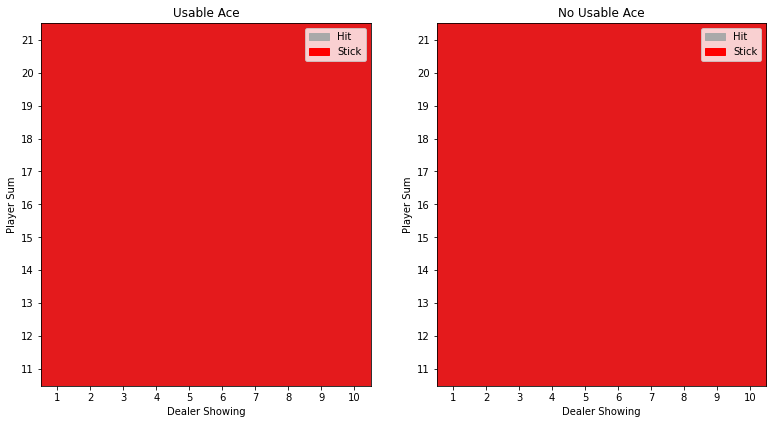

In [54]:
plot_strategy()

Compare the strategy that your agent learned to the optimal Blackjack strategy, shown below on the left. It should look pretty similar!

(Notice that the grid layouts differ a bit between our visualization and the one below; we plot the best actions aligned with the tick marks, whereas the following figure plots the best actions in between tick marks).


![alt text](https://ankonzoid.github.io/LearningX/classical_RL/blackjack/images/coverart.png)
